# Use BlackJAX with PyMC v4
Author: Martin Ingram, based on the notebook for PyMC3 by Kaustubh Chaudhari

In [1]:
import jax
import pymc as pm
from pymc.sampling_jax import get_jaxified_logp
import numpy as np
import blackjax.nuts as nuts
import blackjax.stan_warmup as stan_warmup

# Just for me to disable the GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

print(f"Running on PyMC3 v{pm.__version__}")

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


Running on PyMC3 v4.0.0


/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/aesara/link/jax/dispatch.py:86: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/master/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/pymc/sampling_jax.py:34: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Data

Please refer to the [original TFP example](https://www.tensorflow.org/probability/examples/Eight_Schools) for a description of the problem and the model that is used.

In [2]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

# Model


In [3]:
with pm.Model() as model:

    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    tau = pm.HalfCauchy("tau", 5.0)

    theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
    theta_1 = mu + tau * theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, shape=J, observed=y)

In [4]:
chains = 4
n_warmup = 1000
n_samples = 1_000

# Sampling using PyMC NUTS Sampler

In [5]:
%%time

with model:
    posterior = pm.sample(draws=n_samples, tune=n_warmup, chains=chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]
/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


CPU times: user 2.77 s, sys: 202 ms, total: 2.97 s
Wall time: 4.98 s


# Sampling using PyMC JAX Numpyro NUTS sampler

In [6]:
%%time

with model:
    hierarchical_trace_jax = pm.sampling_jax.sample_numpyro_nuts(
        n_samples, target_accept=0.9, chains=chains, tune=n_warmup 
    )

Compiling...


/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/aesara/graph/opt.py:232: UserWarning: Supervisor is not added. Please build a FunctionGraphvia aesara.compile.function.types.std_graph()or add the Supervisor class manually.
  sub_prof = optimizer.optimize(fgraph)
2022-01-12 12:42:47.768490: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Compilation time =  0 days 00:00:00.219755
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0 days 00:00:03.857859
Transforming variables...
Transformation time =  0 days 00:00:00.025475
CPU times: user 3.32 s, sys: 130 ms, total: 3.45 s
Wall time: 4.22 s


/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/aesara/graph/opt.py:232: UserWarning: Supervisor is not added. Please build a FunctionGraphvia aesara.compile.function.types.std_graph()or add the Supervisor class manually.
  sub_prof = optimizer.optimize(fgraph)


# Sampling using BlackJax

## Configuring the model for BlackJax


In [7]:
seed = jax.random.PRNGKey(1234)

logp_fn_jax = get_jaxified_logp(model)

rv_names = [rv.name for rv in model.value_vars]
initial_point = model.recompute_initial_point()
init_state = [initial_point[rv_name] for rv_name in rv_names]
init_state_batched = jax.tree_map(lambda x: np.repeat(x[None, ...], chains, axis=0), init_state)

initial_state = jax.vmap(nuts.new_state, in_axes=(0, None))(init_state_batched, logp_fn_jax)

In [8]:
%%time

# Warmup
kernel_factory = lambda step_size, inverse_mass_matrix: nuts.kernel(
    logp_fn_jax, step_size, inverse_mass_matrix
)

init_seeds = jax.random.split(seed, 4)

warmup_fn = lambda seed, init_state: stan_warmup.run(seed, kernel_factory, init_state, n_warmup)

last_state, (step_size, inverse_mass_matrix), _ = jax.vmap(warmup_fn)(init_seeds, initial_state)

CPU times: user 16.3 s, sys: 18.6 ms, total: 16.3 s
Wall time: 16.3 s


In [9]:
%%time

# Sampling
def inner_inference_loop(
    rng_key, step_size, inverse_mass_matrix, initial_state, num_samples, kernel_factory
):
    
    kernel = kernel_factory(step_size, inverse_mass_matrix)
    
    def one_step(state, rng_key):
        
        key = jax.random.split(rng_key, 2)
        state, info = kernel(key, state)
        return state, (state, info)
    
    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    
    return states

from functools import partial

to_vmap = partial(inner_inference_loop, num_samples=n_samples, kernel_factory=kernel_factory)

# TODO: Should I be doing this?
seed = jax.random.PRNGKey(12345)
start_keys = jax.random.split(seed, 4)

results = jax.vmap(to_vmap)(start_keys, step_size, inverse_mass_matrix, last_state)

CPU times: user 5.84 s, sys: 15.4 ms, total: 5.85 s
Wall time: 5.84 s


In [17]:
step_size

DeviceArray([0.00015432, 0.00018527, 0.00016758, 0.00019071], dtype=float64)

In [21]:
inverse_mass_matrix[3]

DeviceArray([9.90143324e-06, 9.90434228e-06, 9.90339854e-06,
             2.27641479e+04, 9.90208592e-06, 2.84121890e-05,
             9.90229951e-06, 9.90304749e-06, 8.14807809e-02,
             9.90586300e-06], dtype=float64)

In [10]:
draw_list = results[0].position

draw_dict = {x: y for x, y in zip(rv_names, draw_list)}

In [11]:
import arviz as az

array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'theta\n2'}>,
        <AxesSubplot:title={'center':'theta\n3'}>],
       [<AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>,
        <AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>]], dtype=object)

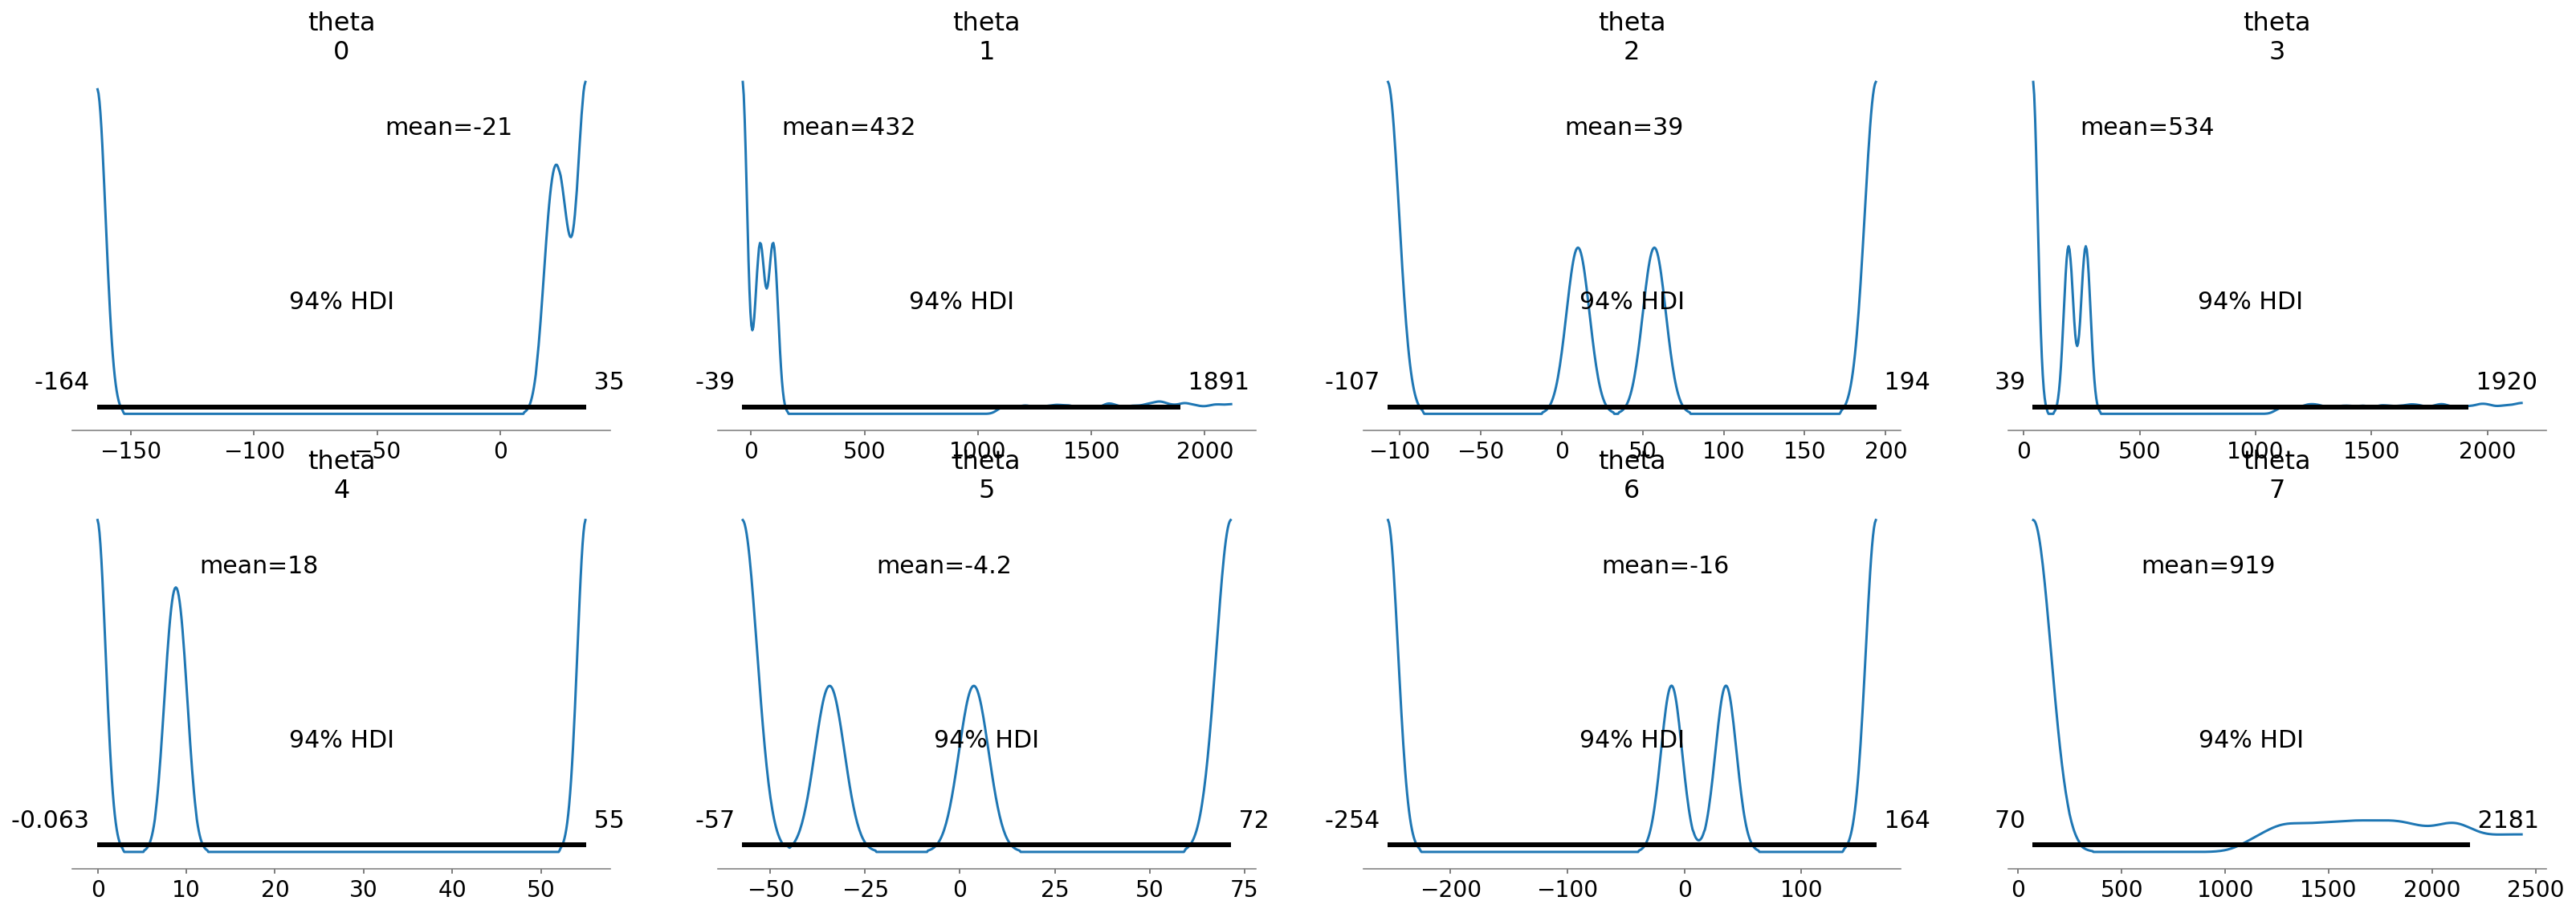

In [31]:
draws_untransformed_arviz = az.from_dict(draw_dict)

# Result I'm getting for theta
az.plot_posterior(draws_untransformed_arviz.posterior['theta'])

array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'theta\n2'}>,
        <AxesSubplot:title={'center':'theta\n3'}>],
       [<AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>,
        <AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>]], dtype=object)

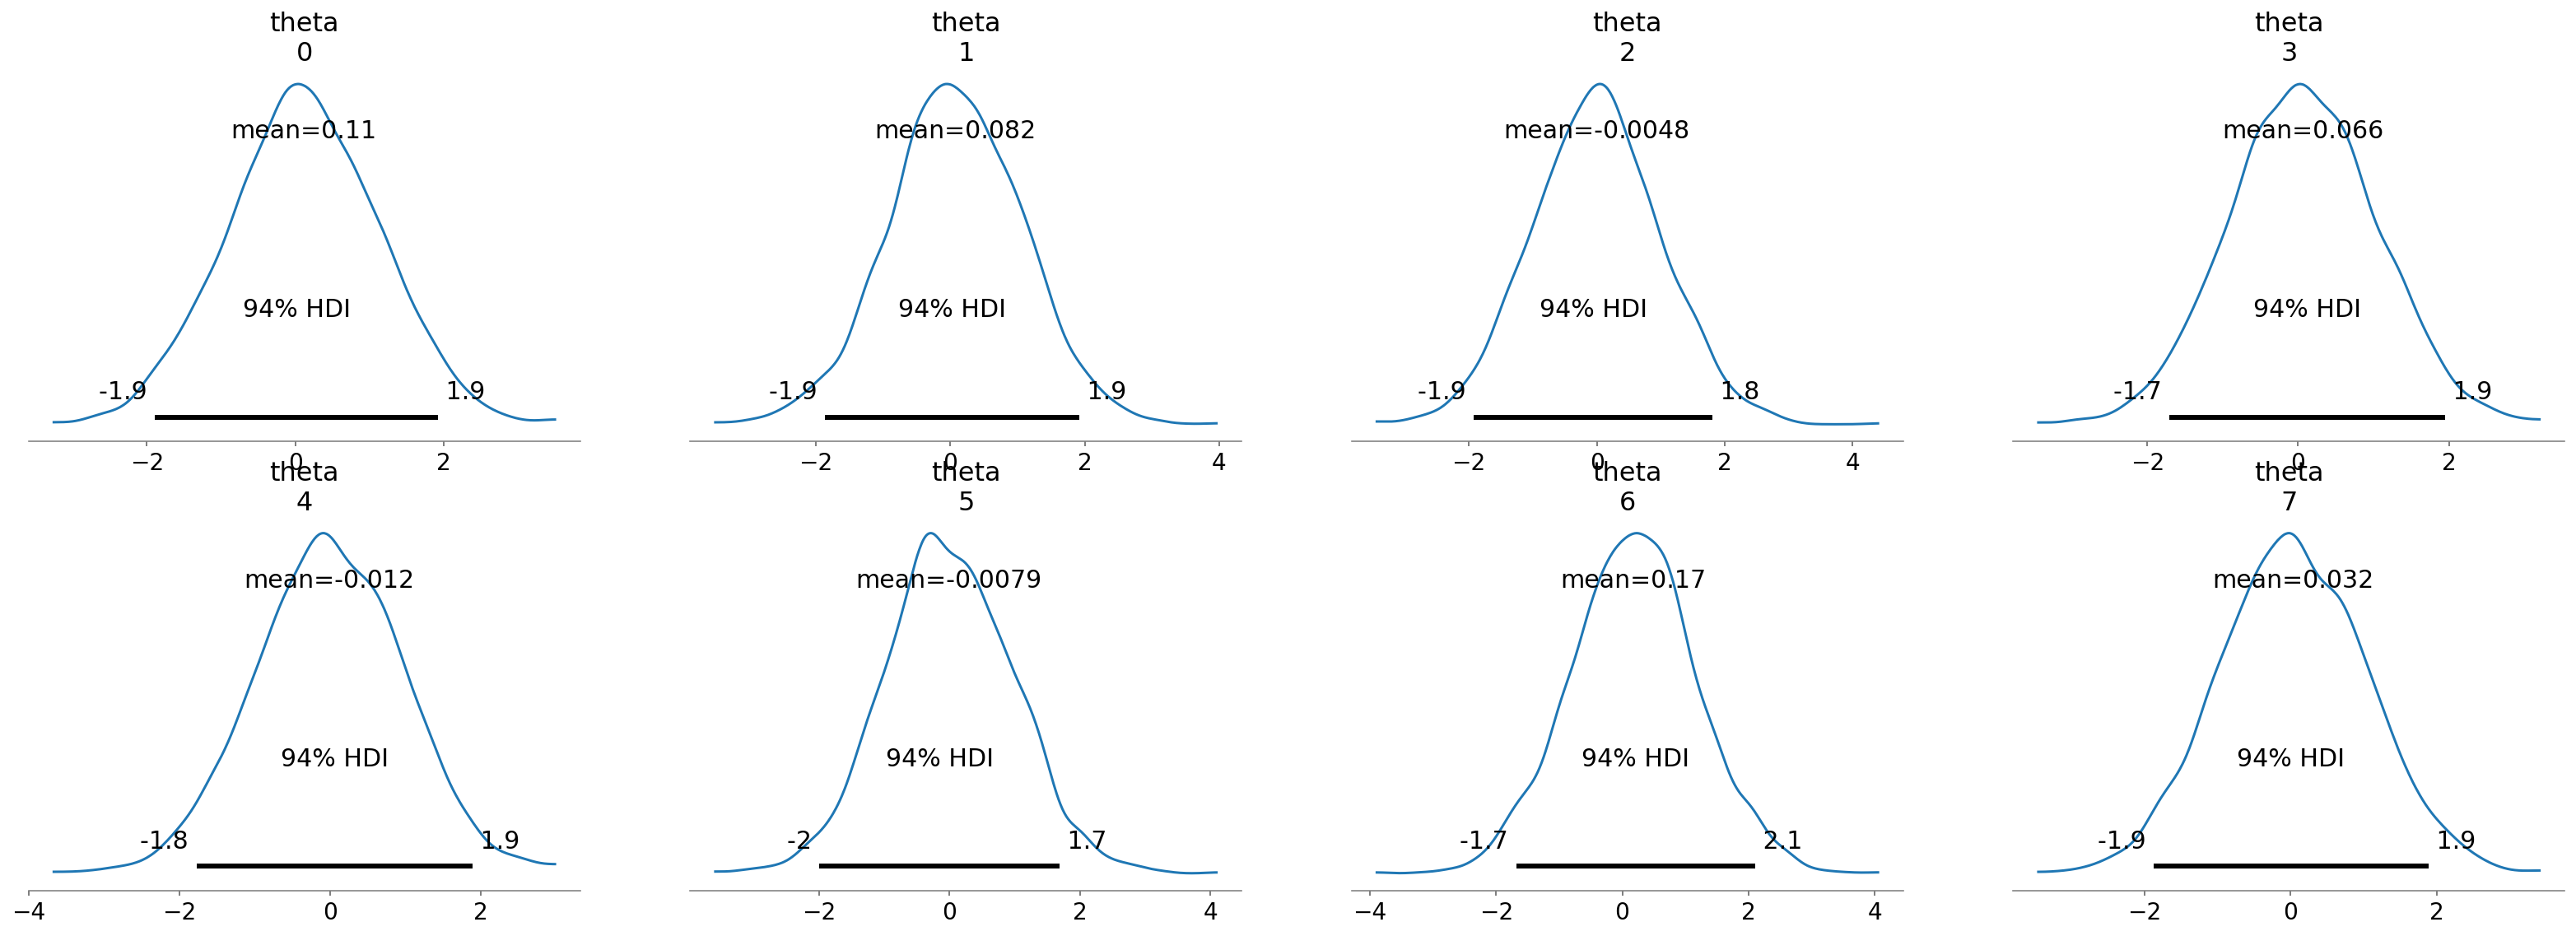

In [32]:
# Result we probably should be getting
az.plot_posterior(posterior.posterior['theta'])

In [ ]:
# Additional work to transform variables (not important here, but seems to work)

In [13]:
from aesara.graph.fg import FunctionGraph
from pymc.util import get_default_varnames
from aesara.graph import optimize_graph
from aesara.link.jax.dispatch import jax_funcify

def transform_raw_samples(model, draw_list, keep_untransformed=False):
    
    var_names = model.unobserved_value_vars
    vars_to_sample = list(get_default_varnames(var_names, include_transformed=keep_untransformed))
    
    mcmc_samples = {}
    
    for v in vars_to_sample:
        fgraph = FunctionGraph(model.value_vars, [v], clone=False)
        optimize_graph(fgraph, include=["fast_run"], exclude=["cxx_only", "BlasOpt"])
        jax_fn = jax_funcify(fgraph)
        result = jax.vmap(jax.vmap(jax_fn))(*draw_list)[0]
        mcmc_samples[v.name] = result
        
    return mcmc_samples

In [14]:
mcmc_samples = transform_raw_samples(model, draw_list)
draws_arviz = az.from_dict(mcmc_samples)

/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/aesara/graph/opt.py:232: UserWarning: Supervisor is not added. Please build a FunctionGraphvia aesara.compile.function.types.std_graph()or add the Supervisor class manually.
  sub_prof = optimizer.optimize(fgraph)


array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'theta\n2'}>,
        <AxesSubplot:title={'center':'theta\n3'}>],
       [<AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>,
        <AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>]], dtype=object)

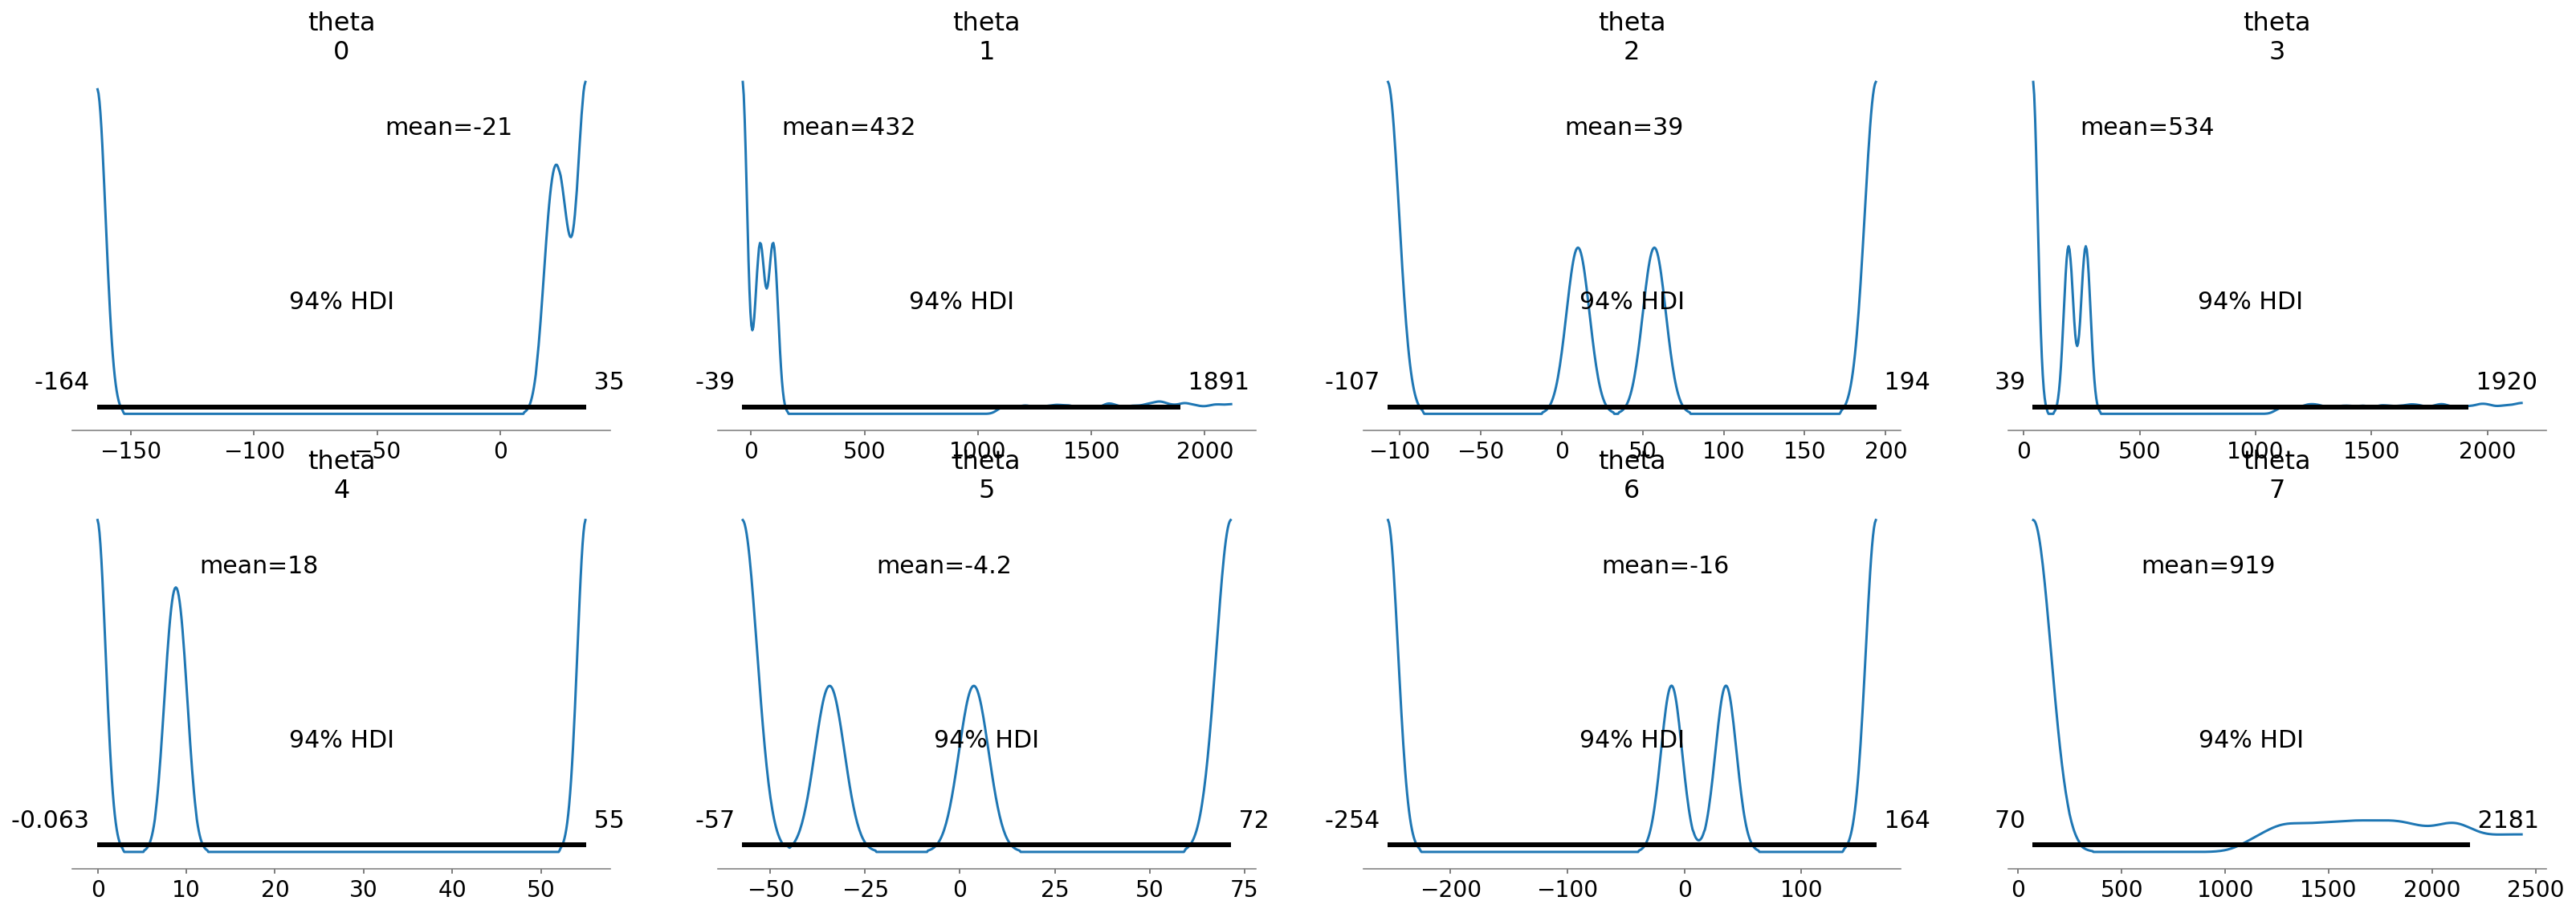

In [29]:
# Result I'm getting for theta
az.plot_posterior(draws_arviz.posterior['theta'])

array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'theta\n2'}>,
        <AxesSubplot:title={'center':'theta\n3'}>],
       [<AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>,
        <AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>]], dtype=object)

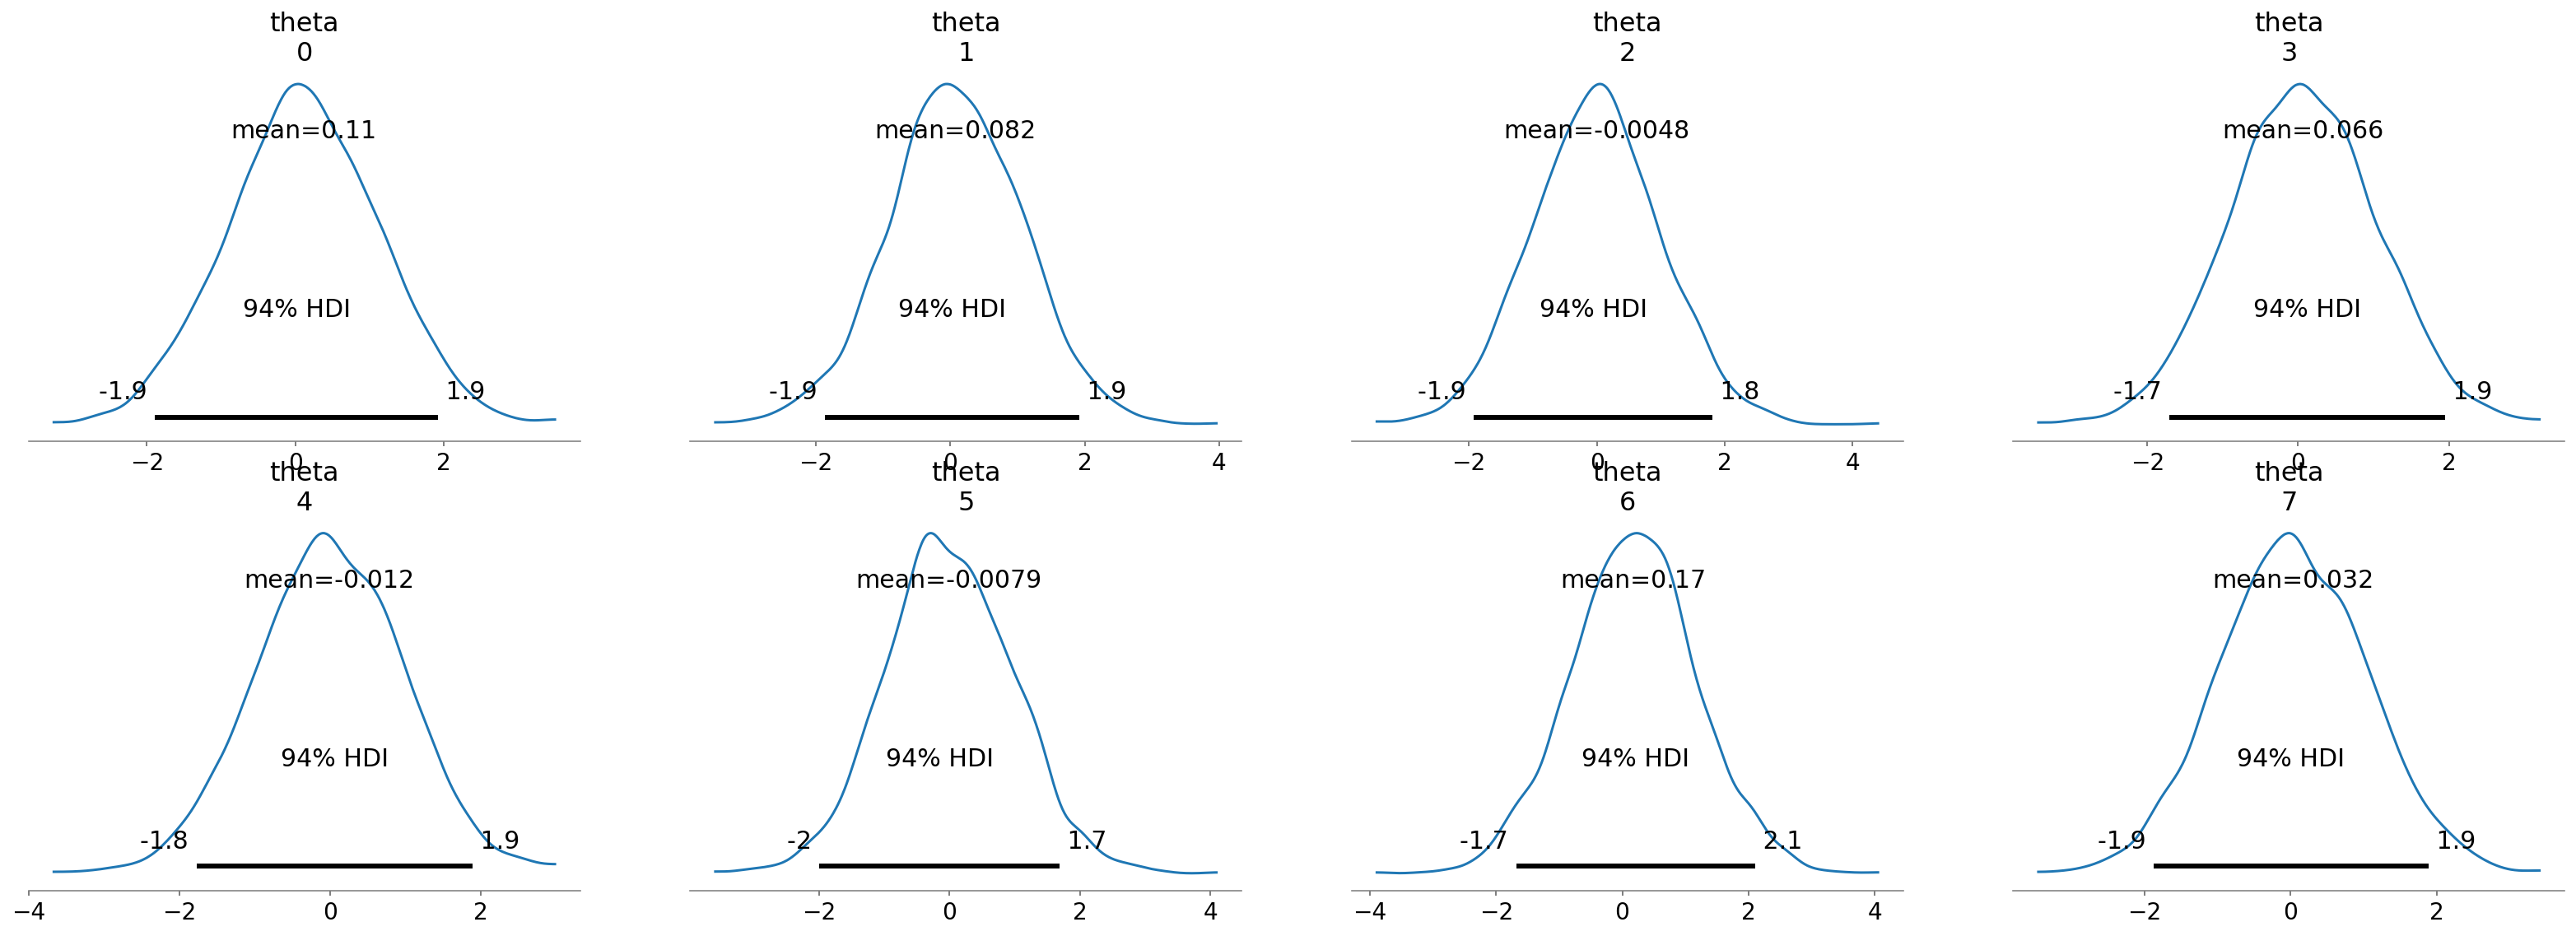

In [30]:
# Result we probably should be getting
az.plot_posterior(posterior.posterior['theta'])